# Libraries

In [1]:
import torch
import os
import re
import fitz # (pymupdf, found this is better than pypdf for our use case, note: licence is AGPL-3.0, keep that in mind if you want to use any code commercially)
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm 
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

# check if GPU is accessible

In [2]:
#check gpu access
if torch.cuda.is_available():
    print("Using GPU: "+torch.cuda.get_device_name(0) + " is available")
else: #we are using cpu
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 2060 is available


# I. Document/Text Processing and Embedding Creation

Ingredients:
* PDF document of choice.
* Embedding model of choice.

Steps:
1. Import PDF document.
2. Process text for embedding (e.g. split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to file for later use (embeddings will store on file for many years or until you lose your hard drive).

## 1. Import PDF document

In [3]:
# Get PDF document
pdf_path = "greg_doucette_cookbook_2_0.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, go to the link in the README to download it.")
else:
  print(f"File {pdf_path} exists.")

File greg_doucette_cookbook_2_0.pdf exists.


In [4]:

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        #text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number+1,
                                 "page_char_count": len(text),
                                 "page_word_count": len(text.split(" ")),
                                 "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)

205it [00:00, 449.87it/s]


In [5]:
len(pages_and_texts)

205

### Data Cleaning

We separate the pages by recipe, table for fruits and table for vegetables.

In [6]:
table_of_contents = pages_and_texts[len(pages_and_texts)-19:len(pages_and_texts)-2]
recipes = pages_and_texts[16:len(pages_and_texts)-21]
vegetables_raw_and_legumes_servings_reference_table=table_of_contents[-3:-1]
fruits_servings_reference_table=table_of_contents[-4]

In [7]:
len(recipes)

168

In [8]:
len(vegetables_raw_and_legumes_servings_reference_table)

2

In [9]:
len(fruits_servings_reference_table)

6

## P_D_I_P_R database creation

We create a dataset with the following columns:
* The page Number
* The directions list
* The Ingredients list
* The preparation time
* The ready in time

In [10]:
df = pd.DataFrame(recipes)
df.head()
df.to_csv('cookbook_data.csv', index=False)

### Remove the empty content (they are images in the book)

In [11]:
#get the rows that contain ingredients and Directions since everything else is plain explanation
df = df[df.text.str.contains('Ingredients|Directions')]

we get now the elements we need from the text

In [12]:
def extract_directions(text: str) -> str:
    # List of separators to use in the search
    separators = [
        "N u t r i t i o n",
        "N o t e",
        "N U T R I T I O N",
        "N O T E",
        "P R E P",
        "T O T A L",
        "V E G E T A R I A N",
        "V E G A N",
        "\nIngredients\n",
        "R E A D Y"
    ]
    
    # Construct a regex pattern to match any of the separators
    separator_pattern = r'|'.join([re.escape(separator) for separator in separators])
    
    # Remove the "number.\n" -> "number. " since it is not useful
    text = re.sub(r'(\d+)\.\n', r'\1. ', text)
    
    # Search for the section "Directions"
    directions_match = re.search(r'Directions\s*([\s\S]*?)\s*(' + separator_pattern + r')', text, re.IGNORECASE)
    if directions_match:
        # Return the found directions
        return directions_match.group(1).strip()
    return None

#we test it on the first 5 rows
df['directions'] = df.text.progress_apply(extract_directions)

100%|██████████| 130/130 [00:00<00:00, 4396.51it/s]


In [13]:
def extract_ingredients(text: str) -> str:
    # List of separators to use in the search
    separators = [
        "N u t r i t i o n",
        "N o t e",
        "N U T R I T I O N",
        "N O T E",
        "P R E P",
        "T O T A L",
        "V E G E T A R I A N",
        "V E G A N",
        "R E A D Y",
        "C L I C K",
    ]
    
    # Construct a regex pattern to match any of the separators
    separator_pattern = r'|'.join([re.escape(separator) for separator in separators])
    
    # Remove the "number.\n" -> "number. " since it is not useful
    text = re.sub(r'(\d+)\.\n', r'\1. ', text)
    
    # Search for the section "Directions"
    ingredients_match = re.search(r'\nIngredients\n\s*([\s\S]*?)\s*(' + separator_pattern + r')', text, re.IGNORECASE)
    if ingredients_match:
        # Return the found ingredients
        return ingredients_match.group(1).strip()
    return None


df['ingredients'] = df.text.progress_apply(extract_ingredients)

100%|██████████| 130/130 [00:00<00:00, 8000.05it/s]


In [14]:
import re
import pandas as pd

# Function to extract prep time and ready in time
def extract_prep_time_and_or_ready_in(text: str) -> dict:
    prep_time = None
    ready_in = None

    # Find all occurrences of "MINUTES" and "HOURS" in uppercase along with their preceding numbers
    times = re.findall(r'(\d+)\s*(MINUTES|HOUR)', text)

    # Find the occurrence of "P R E P  T I M E" and "R E A D Y  I N"
    prep_time_index = text.find("\nP R E P  T I M E")
    ready_in_index = text.find("\nR E A D Y  I N")

    if prep_time_index != -1 and ready_in_index != -1:
        # Determine the order of prep time and ready in time based on their positions in the text
        if prep_time_index < ready_in_index:
            if len(times) > 0:
                prep_time = times[0][0] + " " + times[0][1] if times[0][1] == "MINUTES" else None
            if len(times) > 1:
                ready_in = times[1][0] + " " + times[1][1]
        else:
            if len(times) > 0:
                ready_in = times[0][0] + " " + times[0][1]
            if len(times) > 1:
                prep_time = times[1][0] + " " + times[1][1] if times[1][1] == "MINUTES" else None
    elif prep_time_index != -1:
        prep_time = times[0][0] + " " + times[0][1] if len(times) > 0 and times[0][1] == "MINUTES" else None
    elif ready_in_index != -1:
        ready_in = times[0][0] + " " + times[0][1] if len(times) > 0 else None

    return {
        "prep_time": prep_time,
        "ready_in": ready_in
    }


# Apply the function to the dataframe
df[['prep_time', 'ready_in']] = df['text'].apply(lambda x: pd.Series(extract_prep_time_and_or_ready_in(x)))


In [15]:
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text,directions,ingredients,prep_time,ready_in
0,17,2206,765,6,551.50,17\nwww.gregdoucette.com\nT H E U L T I M A T...,1. Pre-heat the oven to 400°F (204°C).\n2. Cho...,M A K E S 1 B A T C H . S E R V I N G \nS I...,20 MINUTES,1 HOUR
1,18,2205,616,8,551.25,18\nwww.gregdoucette.com\nT H E U L T I M A T...,"1. In a bowl, add egg whites, sweetener, cinna...",M A K E S 1 S E R V I N G\n180g (¾ cup) egg ...,10 MINUTES,20 MINUTES
3,20,2736,653,3,684.00,20\nwww.gregdoucette.com\nT H E U L T I M A T...,"1. In a bowl, mix the filling ingredients with...",M A K E S 2 R O L L - U P S ( 1 S E R V I ...,10 MINUTES,20 MINUTES
4,21,2019,556,8,504.75,21\nwww.gregdoucette.com\nT H E U L T I M A T...,"1. In a bowl, add egg whites, sweetener, cinna...",M A K E S 1 S E R V I N G\n180g (¾ cup) egg ...,10 MINUTES,20 MINUTES
5,22,2312,816,8,578.00,22\nwww.gregdoucette.com\nT H E U L T I M A T...,1. Pre-heat the oven to 400°F (204°C).\n2. Cut...,M A K E S 1 B A T C H . S E R V I N G \nS I...,15 MINUTES,1 HOUR


We identified that \u00b0F is Fahrenheit (°F) and \u00b0C is Celcius (°C) So we replace it. And we know it is only in the direction, because, why would the degree too cook be in the ingredient list ? 

We remove the "ass" in the dataset... because we are good boys.

In the cookbook, there are notes and links that would not be necessary, as such we will remove it.
It starts with "click to...", we don't need it, so we remove it.

In [16]:
# List of phrases to remove
click_to_and_get_strings = [
    "CLICK TO ORDER ICON MEALS PROTEIN BREAD",
    "CLICK TO ORDER LOW-CALORIE SYRUP",
    "CLICK TO PURCHASE GUAR GUM",
    "CLICK TO ORDER WALDEN FARMS SYRUP",
    "CLICK TO PURCHASE A NINJA BLENDER",
    "CLICK TO PURCHASE MUSCLE EGG",
    "CLICK TO PURCHASE LIQUID MUSCLE",
    "CLICK TO PURCHASE MISSION CARB BALANCE TORTILLA",
    "CLICK TO PURCHASE YVES VEGGIE TOFU DOGS",
    "CLICK TO PURCHASE PALMINI LOW-CARB LASAGNA",
    "CLICK TO PURCHASE VEGGIE GROUND \"MEAT\"",
    "CLICK TO PURCHASE SUGAR-FREE CHOCOLATE SAUCE",
    "GET SUGAR-FREE CHOCOLATE JELL-O PUDDING",
    "GET CHOCOLATE SUGAR-FREE JELLO PUDDING MIX",
    "GET GUAR GUM",
    "GET PB2 POWDERED PEANUT BUTTER",
    "CLICK TO PURCHASE PB2 POWDERED PEANUT BUTTER",
    "CLICK TO PURCHASE PUMPKIN PURÉE",
    "CLICK TO PURCHASE PB2 (POWDERED PEANUT BUTTER)",
    "CLICK TO PURCHASE FIBER ONE BROWNIE BAR",
    "CLICK TO PURCHASE CHOCOLATE PB2 POWDER",
    "GET BANANA SUGAR-FREE JELLO PUDDING MIX",
    "CLICK TO PURCHASE WALDEN FARMS MAPLE WALNUT SYRUP",
    "CLICK TO PURCHASE HERSHEY'S HEALTH SHELL TOPPING",
    "CLICK TO PURCHASE SUGAR-FREE JELLO CHEESECAKE PUDDING POWDER",
    "CLICK TO PURCHASE LIBBY’S 100% PURE PUMPKIN",
    "CLICK TO PURCHASE SUGAR-FREE VANILLA PUDDING JELL-O",
    "GET CHOCOLATE PB2 POWDERED PEANUT BUTTER",
]

# Function to remove specific phrases from text
def remove_phrases(text, phrases):
    for phrase in phrases:
        text = text.replace(phrase, '')
    return text

# Apply cleaning to all texts in the dataset
df['text'] = df['text'].apply(lambda x: remove_phrases(x, click_to_and_get_strings))

# Save the cleaned data to a new CSV file
cleaned_file_path = 'cleaned_cookbook_data.csv'
df.to_csv(cleaned_file_path, index=False)

# Display the first few rows of the cleaned DataFrame
df.head()


,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text,directions,ingredients,prep_time,ready_in
0,17,2206,765,6,551.50,17\nwww.gregdoucette.com\nT H E U L T I M A T...,1. Pre-heat the oven to 400°F (204°C).\n2. Cho...,M A K E S 1 B A T C H . S E R V I N G \nS I...,20 MINUTES,1 HOUR
1,18,2205,616,8,551.25,18\nwww.gregdoucette.com\nT H E U L T I M A T...,"1. In a bowl, add egg whites, sweetener, cinna...",M A K E S 1 S E R V I N G\n180g (¾ cup) egg ...,10 MINUTES,20 MINUTES
3,20,2736,653,3,684.00,20\nwww.gregdoucette.com\nT H E U L T I M A T...,"1. In a bowl, mix the filling ingredients with...",M A K E S 2 R O L L - U P S ( 1 S E R V I ...,10 MINUTES,20 MINUTES
4,21,2019,556,8,504.75,21\nwww.gregdoucette.com\nT H E U L T I M A T...,"1. In a bowl, add egg whites, sweetener, cinna...",M A K E S 1 S E R V I N G\n180g (¾ cup) egg ...,10 MINUTES,20 MINUTES
5,22,2312,816,8,578.00,22\nwww.gregdoucette.com\nT H E U L T I M A T...,1. Pre-heat the oven to 400°F (204°C).\n2. Cut...,M A K E S 1 B A T C H . S E R V I N G \nS I...,15 MINUTES,1 HOUR


In [17]:
#we replace de 1 hour by 60 minutes
df['ready_in'] = df['ready_in'].str.replace('1 HOUR', '60 MINUTES')

In [18]:
#we replace the column name ready_in by ready_in_minutes and prep_time by prep_time_minutes
df.rename(columns={'ready_in': 'ready_in_minutes', 'prep_time': 'prep_time_minutes'}, inplace=True)

#we remove the words MINUTES and HOUR
df['ready_in_minutes'] = df['ready_in_minutes'].str.replace('MINUTES', '')
df['prep_time_minutes'] = df['prep_time_minutes'].str.replace('MINUTES', '')
#we remove useless spaces
df['ready_in_minutes'] = df['ready_in_minutes'].str.strip()
df['prep_time_minutes'] = df['prep_time_minutes'].str.strip()

In [19]:
#we drop the useless columns LIKE page_number, page_char_count, page_word_count, page_sentence_count_raw, page_token_count
df.drop(columns=['text','page_char_count', 'page_word_count', 'page_sentence_count_raw', 'page_token_count'], inplace=True)

In [20]:
df.head()

,page_number,directions,ingredients,prep_time_minutes,ready_in_minutes
0,17,1. Pre-heat the oven to 400°F (204°C).\n2. Cho...,M A K E S 1 B A T C H . S E R V I N G \nS I...,20,60
1,18,"1. In a bowl, add egg whites, sweetener, cinna...",M A K E S 1 S E R V I N G\n180g (¾ cup) egg ...,10,20
3,20,"1. In a bowl, mix the filling ingredients with...",M A K E S 2 R O L L - U P S ( 1 S E R V I ...,10,20
4,21,"1. In a bowl, add egg whites, sweetener, cinna...",M A K E S 1 S E R V I N G\n180g (¾ cup) egg ...,10,20
5,22,1. Pre-heat the oven to 400°F (204°C).\n2. Cut...,M A K E S 1 B A T C H . S E R V I N G \nS I...,15,60


In [21]:
df.to_csv('P_D_I_P_R.csv', index=False)

We completed our first database. That contains the directions of the recipe, along with the ingredients, the page number, the prep time and the ready in time. Now we will focus on creating a second database that contains the recipes title, along with the macronutrients and the page.

##  P_T_C_F_C_F_P database creation

We create a dataset with the following columns:
* The page Number
* The title of the recipe
* The calories
* The Fat content
* the Carb content
* The fiber content
* The Protein content

We start of by getting the associated page.

In [22]:
master_recipe_nutrition_table = table_of_contents[:-4]
master_recipe_nutrition_table

[{'page_number': 187,
  'page_char_count': 1625,
  'page_word_count': 142,
  'page_sentence_count_raw': 2,
  'page_token_count': 406.25,
  'text': '187\nCopyright Coach Greg Inc. 2020\nwww.gregdoucette.com\nBack to Table of Contents\nMaster Recipe Nutrition Table\nPage\nRecipe\nCalories \nPer \nServing\nFat (g) \nper \nserving\nCarbs \n(g) per \nserving\nFiber \n(g) per \nserving\nProtein (g) \nper serving\nVegan\nVegetarian\n17\nAnabolic Apple Pie Breakfast Bake - \nEntire Batch\n3350\n17\n464\n46\n265\nY\n17\nAnabolic Apple Pie Breakfast Bake - \nLarge Serving\n560\n3\n77\n8\n44\nY\n17\nAnabolic Apple Pie Breakfast Bake - Small \nServing\n280\n1\n39\n4\n22\nY\n18\nAnabolic French Toast - Per Serving\n270\n1\n30\n6\n28\nY\n18\nAnabolic French Toast - Large\n400\n2\n48\n9\n45\nY\n20\nBanana "No"Tella French Toast Roll-Ups \n- Small\n340\n4\n54\n5\n28\nY\n20\nBanana "No"Tella French Toast Roll-Ups - \nMedium\n680\n8\n93\n10\n57\nY\n20\nBanana "No"Tella French Toast Roll-Ups \n- Large\n7

We are going to do this page by page.

In [23]:
#definition of the method to retreive the dataframe
def get_dataframe_from_table_page(text):

    #first off we remove the lines until we find the first occurence of "Vegetarian" and we drop it along with everything that came before him.
    text = text[text.find("Vegetarian"):].replace("Vegetarian","")

    #when we see the pattern of any \n next to "-" we remove the "\n"
    text = text.replace("\n-","-").replace("\n -"," -").replace("-\n","- ").replace("\n-\n","-").replace("- \n","- ")

    # if we see \n next to serving or servings we remove it
    text = re.sub(r'\n(?=\b[sS]erving[s]?\b)', '', text)

    # #we remove the first \n
    text = text.replace("\n"," ",1)

    #we remove "\nY\n"
    text = text.replace("\nY","")

    array=text.split("\n")
    #we remove unwanted spaces
    array = [i.strip() for i in array]
    #we remove empty strings
    array = list(filter(None, array))

    #on parcours le tableau, et nous calculons la longueur de chaque element. Si la le voisin i+1 est plus long que 3 c'est que c'est un text qui est coupé en deux, on le merge avec le voisin i. SAUF si i a une taille infieur ou égale à 3, car dans ce cas i est un nombre.
    for i in range(len(array) - 1):
        if len(array[i+1]) > 3 and len(array[i]) > 3 and not array[i+1].isnumeric() and not is_number_without_period(array[i]):
            array[i] = array[i] + " " + array[i+1]
            array[i+1] = ""

    # we remove the empty strings
    array = list(filter(None, array))
    #we now that the first 7 elements are 1 recipe, so we can append by chunks of 7. The first element is the page, the second the recipe, the third the calories, the fourth the fat, the fifth the carbs, the sixth the fiber, the seventh the protein.

    pages=[]
    recipes=[]
    calories=[]
    fat=[]
    carbs=[]
    fiber=[]
    protein=[]

    for i in range(0,len(array),7):
        pages.append(array[i])
        recipes.append(array[i+1])
        calories.append(array[i+2])
        fat.append(array[i+3])
        carbs.append(array[i+4])
        fiber.append(array[i+5])
        protein.append(array[i+6])
        

    #we create a dictionnary to store the data
    nutrition_data = {
        "Page": pages,
        "Recipe": recipes,
        "Calories Per Serving": calories,
        "Fat (g) per serving": fat,
        "Carbs (g) per serving": carbs,
        "Fiber (g) per serving": fiber,
        "Protein (g) per serving": protein,
    }

    #we create a dataframe
    page_dataframe = pd.DataFrame(nutrition_data)

    return page_dataframe


# to remove . in the page number
def is_number_without_period(s):
    return s.replace(".", "").isnumeric()

### Processing Pages of nutritional table

In [24]:
for index, page in enumerate(master_recipe_nutrition_table):
    print(f"Processing page {index}...")
    df = get_dataframe_from_table_page(page['text'])
    df.to_csv(f'nutrition_table_{index}.csv', index=False)

Processing page 0...
Processing page 1...
Processing page 2...
Processing page 3...
Processing page 4...
Processing page 5...
Processing page 6...
Processing page 7...
Processing page 8...
Processing page 9...
Processing page 10...
Processing page 11...
Processing page 12...


In [25]:
#load all the nutrition_table csv files and fuse them into one
import os
import glob

#we load the pages one by one
page_1_dataframe = pd.read_csv('nutrition_table_0.csv')
page_2_dataframe = pd.read_csv('nutrition_table_1.csv')
page_3_dataframe = pd.read_csv('nutrition_table_2.csv')
page_4_dataframe = pd.read_csv('nutrition_table_3.csv')
page_5_dataframe = pd.read_csv('nutrition_table_4.csv')
page_6_dataframe = pd.read_csv('nutrition_table_5.csv')
page_7_dataframe = pd.read_csv('nutrition_table_6.csv')
page_8_dataframe = pd.read_csv('nutrition_table_7.csv')
page_9_dataframe = pd.read_csv('nutrition_table_8.csv')
page_10_dataframe = pd.read_csv('nutrition_table_9.csv')
page_11_dataframe = pd.read_csv('nutrition_table_10.csv')
page_12_dataframe = pd.read_csv('nutrition_table_11.csv')
page_13_dataframe = pd.read_csv('nutrition_table_12.csv')

#we concatenate all the dataframes
master_recipe_nutrition_table = pd.concat([page_1_dataframe, page_2_dataframe, page_3_dataframe, page_4_dataframe, page_5_dataframe, page_6_dataframe, page_7_dataframe, page_8_dataframe, page_9_dataframe, page_10_dataframe, page_11_dataframe, page_12_dataframe, page_13_dataframe])

In [26]:
# we order it by the page number
P_T_C_F_C_F_P_dataframe = master_recipe_nutrition_table.sort_values(by='Page')
P_T_C_F_C_F_P_dataframe

,Page,Recipe,Calories Per Serving,Fat (g) per serving,Carbs (g) per serving,Fiber (g) per serving,Protein (g) per serving
0,17,Anabolic Apple Pie Breakfast Bake - Entire Batch,3350,17,464,46,265
1,17,Anabolic Apple Pie Breakfast Bake - Large Serving,560,3,77,8,44
2,17,Anabolic Apple Pie Breakfast Bake - Small Serving,280,1,39,4,22
3,18,Anabolic French Toast - Per Serving,270,1,30,6,28
4,18,Anabolic French Toast - Large,400,2,48,9,45
...,...,...,...,...,...,...,...
9,184,Chocolate Strawberry PB Proteinsicles - Per Se...,303,5,21,8,45
10,185,Strawberry Cheesecake Proteinsicles - Batch,1160,16,92,28,160
11,185,Strawberry Cheesecake Proteinsicles - Per Serving,289,4,23,7,40
12,186,Vanilla Berry Proteinsicles - Batch,1020,12,84,24,152


based on our observation on the cookbook and the dataset. For unknown reason the page number was not respected starting from 48 became 49, and from then on, all numbers are +1, we simply remove this additionned value and reset the input.

In [27]:
#from every row starting from 51 we reduce the page number by 1
#we replace the page column by the new values
for i in range(51,len(P_T_C_F_C_F_P_dataframe)):
    P_T_C_F_C_F_P_dataframe.iloc[i,0] = int(P_T_C_F_C_F_P_dataframe.iloc[i,0])-1

In [28]:
P_T_C_F_C_F_P_dataframe

,Page,Recipe,Calories Per Serving,Fat (g) per serving,Carbs (g) per serving,Fiber (g) per serving,Protein (g) per serving
0,17,Anabolic Apple Pie Breakfast Bake - Entire Batch,3350,17,464,46,265
1,17,Anabolic Apple Pie Breakfast Bake - Large Serving,560,3,77,8,44
2,17,Anabolic Apple Pie Breakfast Bake - Small Serving,280,1,39,4,22
3,18,Anabolic French Toast - Per Serving,270,1,30,6,28
4,18,Anabolic French Toast - Large,400,2,48,9,45
...,...,...,...,...,...,...,...
9,183,Chocolate Strawberry PB Proteinsicles - Per Se...,303,5,21,8,45
10,184,Strawberry Cheesecake Proteinsicles - Batch,1160,16,92,28,160
11,184,Strawberry Cheesecake Proteinsicles - Per Serving,289,4,23,7,40
12,185,Vanilla Berry Proteinsicles - Batch,1020,12,84,24,152


what we now need to do is is to manually set the vegan and vegetarian column, we can check in the cookbook each recipe to see if it is vegan or vegetarian. 
We can see that on page 187 there are all recipe are vegetaria (except 29,30,31) and all ar non vegan. So we can just write a python hard code that does that.

In [29]:
#what we now need to do is is to manually set the vegan and vegetarian column, we can check in the cookbook each recipe to see if it is vegan or vegetarian. We can see that on page 187 there are all recipe are vegetaria (except 29,30,31) and all ar non vegan. So we can just write a python hard code that does that.

#pages that are vegan:
vegan_pages = [51,66,76,78,91,121,142,152,164,169,196,170,175]

#we create the vegan column
P_T_C_F_C_F_P_dataframe['Vegan'] = "No"

#we set the vegan column to Yes for the pages that are vegan
for page in vegan_pages:
    P_T_C_F_C_F_P_dataframe.loc[P_T_C_F_C_F_P_dataframe['Page'] == page, 'Vegan'] = "Yes"

# we set the ChocolateProtein Mug Cake to no, because it is not vegan
P_T_C_F_C_F_P_dataframe.loc[P_T_C_F_C_F_P_dataframe['Recipe'] == 'Chocolate Protein Mug Cake', 'Vegan'] = "No"

In [30]:
#we set the vegetarian column

#we set every column as vegetarian
P_T_C_F_C_F_P_dataframe['Vegetarian'] = "Yes"

#now we just set to no the recipes that are not vegetarian
non_vegetarian_pages=[29,30,31,
                      
                      63,64,68,70,
                      
                      75,
                      80,
                      85,
                      86,87,89,90,92,93,98,99,101,102,

                      105,107,108,110,111,113,115,116,118,

                      126,

                      152,

                      ]

for page in non_vegetarian_pages:
    P_T_C_F_C_F_P_dataframe.loc[P_T_C_F_C_F_P_dataframe['Page'] == page, 'Vegetarian'] = "No"


#Egg White Wrap & Cauliflower PIzza Crust - Per 2 Meat Lovers Pizza is not vegetarian 
P_T_C_F_C_F_P_dataframe.loc[P_T_C_F_C_F_P_dataframe['Recipe'] == 'Cauliflower PIzza Crust - Per 2 Meat Lovers Pizza', 'Vegetarian'] = "No"
# Cauliflower PIzza Crust - Per 2 Meat Lovers Pizza is not vegetarian
P_T_C_F_C_F_P_dataframe.loc[P_T_C_F_C_F_P_dataframe['Recipe'] == 'Cauliflower PIzza Crust - Per 2 Meat Lovers Pizza', 'Vegetarian'] = "No"
# Sloppy Greg Sandwich - Total is not vegetarian
P_T_C_F_C_F_P_dataframe.loc[P_T_C_F_C_F_P_dataframe['Recipe'] == 'Sloppy Greg Sandwich - Total', 'Vegetarian'] = "No"
# Sloppy Greg Sandwich - Per Serving is not vegetarian
P_T_C_F_C_F_P_dataframe.loc[P_T_C_F_C_F_P_dataframe['Recipe'] == 'Sloppy Greg Sandwich - Per Serving', 'Vegetarian'] = "No"
# Grilled Chicken Wrap with Mango Relish - 1 Wrap is not vegetarian
P_T_C_F_C_F_P_dataframe.loc[P_T_C_F_C_F_P_dataframe['Recipe'] == 'Grilled Chicken Wrap with Mango Relish - 1 Wrap', 'Vegetarian'] = "No"
# Egg Whites on Flatout Light OR La Tortilla OR 90-110 Calorie Wrap of Choice is vegetarian
P_T_C_F_C_F_P_dataframe.loc[P_T_C_F_C_F_P_dataframe['Recipe'] == 'Egg Whites on Flatout Light OR La Tortilla OR 90-110 Calorie Wrap of Choice', 'Vegetarian'] = "Yes"
# Egg Whites on Joseph's Lavash is vegetarian
P_T_C_F_C_F_P_dataframe.loc[P_T_C_F_C_F_P_dataframe['Recipe'] == 'Egg Whites on Joseph\'s Lavash', 'Vegetarian'] = "Yes"

Now we succeded, we can create a category based on the table of content. 
* Breakfast: all pages from 17 to 60
* Appetizer: all pages from 62 to 67
* Tacos, Wraps and Sandwiches : all pages from 70 to 92
* Dinner: 95 to 122
* Treats: 125 to 156
* Dessert: 158 to 185

In [31]:
# Now we succeded, we can create a category based on the table of content. 
# * Breakfast: all pages from 17 to 60
# * Appetizer: all pages from 62 to 67
# * Tacos, Wraps and Sandwiches : all pages from 70 to 92
# * Dinner: 95 to 122
# * Treats: 125 to 156
# * Dessert: 158 to 185

#we create the category column
P_T_C_F_C_F_P_dataframe['Category'] = "Breakfast"
#we set the category column to the right category
P_T_C_F_C_F_P_dataframe.loc[P_T_C_F_C_F_P_dataframe['Page'].between(62, 67), 'Category'] = "Appetizer"
P_T_C_F_C_F_P_dataframe.loc[P_T_C_F_C_F_P_dataframe['Page'].between(70, 92), 'Category'] = "Tacos, Wraps and Sandwiches"
P_T_C_F_C_F_P_dataframe.loc[P_T_C_F_C_F_P_dataframe['Page'].between(95, 122), 'Category'] = "Dinner"
P_T_C_F_C_F_P_dataframe.loc[P_T_C_F_C_F_P_dataframe['Page'].between(125, 156), 'Category'] = "Treats"
P_T_C_F_C_F_P_dataframe.loc[P_T_C_F_C_F_P_dataframe['Page'].between(158, 186), 'Category'] = "Dessert"


In [32]:
#we save the dataframe
P_T_C_F_C_F_P_dataframe.to_csv('P_T_C_F_C_F_P.csv', index=False)

In [33]:
#Optional, we can delete the nutrition_table csv files
files = glob.glob('nutrition_table_*.csv')
for f in files:
    os.remove(f)

### Dataset Optimizations Possibilities:
- On the PTCFCFP dataset, we need to correct the pages, some recipes do not exist and must be deleted.
  - Ex: "Hot Hamburg","Ham and Cheese - Regular Ass White Bread","Chicken Burger" neither do "PB2 and Jam Sandwhich - ICON","PB2 and Jam Sandwhich - Ezekiel","PB2 and Jam Sandwhich - Regular Ass White Bread"
- Add another of the Fruits and Vegetable dataset for better informations.


### Get final dataset "data"
We have now the 2 Databases to have all the informations of the recipes. What we can do now is potentially fuse them into one to have it in one single Dataset. We can create a Dataset that contains the following structure:
* Page number
* page_char_count
* page_word_count
* page_sentence_count_raw
* page_token_count
* Recipe information that is composed of the "title", "ingredients", "directions", "Prep_and_ready_time_in_minutes","Diet" and "category.

In [34]:
#we Creat a dataframe called data that contains the following columns: Page, Recipe

#we have our 2 datasets P_D_I_P_R.csv and P_T_C_F_C_F_P.csv :

#we load the dataframes
P_D_I_P_R_dataframe = pd.read_csv('P_D_I_P_R.csv')
P_T_C_F_C_F_P_dataframe = pd.read_csv('P_T_C_F_C_F_P.csv')


In [35]:
P_D_I_P_R_dataframe

,page_number,directions,ingredients,prep_time_minutes,ready_in_minutes
0,17,1. Pre-heat the oven to 400°F (204°C).\n2. Cho...,M A K E S 1 B A T C H . S E R V I N G \nS I...,20.0,60
1,18,"1. In a bowl, add egg whites, sweetener, cinna...",M A K E S 1 S E R V I N G\n180g (¾ cup) egg ...,10.0,20
2,20,"1. In a bowl, mix the filling ingredients with...",M A K E S 2 R O L L - U P S ( 1 S E R V I ...,10.0,20
3,21,"1. In a bowl, add egg whites, sweetener, cinna...",M A K E S 1 S E R V I N G\n180g (¾ cup) egg ...,10.0,20
4,22,1. Pre-heat the oven to 400°F (204°C).\n2. Cut...,M A K E S 1 B A T C H . S E R V I N G \nS I...,15.0,60
...,...,...,...,...,...
125,180,1. Add all ingredients to a blender. Blend for...,NaN,10.0,10
126,181,1. Add all ingredients to a blender. Blend for...,M A K E S 1 M E D I U M \nS E R V I N G\n50g...,10.0,10
127,182,1. Add all ingredients to a blender. Pulse ble...,M A K E S 1 B A T C H ( A P P R O X . \n4 ...,20.0,5 HOUR
128,183,1. Add all ingredients to a blender. Pulse ble...,M A K E S 1 B A T C H \n( A P P R O X . 4 ...,20.0,5 HOUR


In [36]:
P_T_C_F_C_F_P_dataframe

,Page,Recipe,Calories Per Serving,Fat (g) per serving,Carbs (g) per serving,Fiber (g) per serving,Protein (g) per serving,Vegan,Vegetarian,Category
0,17,Anabolic Apple Pie Breakfast Bake - Entire Batch,3350,17,464,46,265,No,Yes,Breakfast
1,17,Anabolic Apple Pie Breakfast Bake - Large Serving,560,3,77,8,44,No,Yes,Breakfast
2,17,Anabolic Apple Pie Breakfast Bake - Small Serving,280,1,39,4,22,No,Yes,Breakfast
3,18,Anabolic French Toast - Per Serving,270,1,30,6,28,No,Yes,Breakfast
4,18,Anabolic French Toast - Large,400,2,48,9,45,No,Yes,Breakfast
...,...,...,...,...,...,...,...,...,...,...
298,183,Chocolate Strawberry PB Proteinsicles - Per Se...,303,5,21,8,45,No,Yes,Dessert
299,184,Strawberry Cheesecake Proteinsicles - Batch,1160,16,92,28,160,No,Yes,Dessert
300,184,Strawberry Cheesecake Proteinsicles - Per Serving,289,4,23,7,40,No,Yes,Dessert
301,185,Vanilla Berry Proteinsicles - Batch,1020,12,84,24,152,No,Yes,Dessert


In [37]:
def get_recipe_from_page(page_number):
    page_data = P_D_I_P_R_dataframe[P_D_I_P_R_dataframe['page_number'] == page_number]
    if page_data.empty:
        return "No data found for the given page number."

    extract_directions = page_data['directions'].values[0]
    extract_ingredients = page_data['ingredients'].values[0]
    extracted_prep_time = page_data['prep_time_minutes'].values[0]
    extracted_ready_in = page_data['ready_in_minutes'].values[0]

    text = f"DIRECTIONS:\n{extract_directions}\n\nINGREDIENTS:\n{extract_ingredients}\n\nPREP TIME (in m): {extracted_prep_time}\n\nREADY IN (in m): {extracted_ready_in}"
    return text

def get_title_and_macros(page_number):
    recipes = P_T_C_F_C_F_P_dataframe[P_T_C_F_C_F_P_dataframe['Page'] == page_number]
    if recipes.empty:
        return "No data found for the given page number."

    text = ""
    for _, recipe in recipes.iterrows():
        title = recipe['Recipe']
        calories = recipe['Calories Per Serving']
        fat = recipe['Fat (g) per serving']
        carbs = recipe['Carbs (g) per serving']
        fiber = recipe['Fiber (g) per serving']
        protein = recipe['Protein (g) per serving']
        text += f"TITLE: {title}\nCALORIES (in kcal): {calories}\nFAT (in g): {fat}\nCARBS (in g): {carbs}\nFIBER (in g): {fiber}\nPROTEIN (in g): {protein}\n\n"
    return text

def get_recipe(page_number):
    title_and_macros = get_title_and_macros(page_number)
    recipe = get_recipe_from_page(page_number)

    page_data = P_T_C_F_C_F_P_dataframe[P_T_C_F_C_F_P_dataframe['Page'] == page_number]
    if page_data.empty:
        return "No data found for the given page number."

    diet = "vegan" if page_data['Vegan'].values[0] == "Yes" else "non-vegan"
    diet += " , vegetarian" if page_data['Vegetarian'].values[0] == "Yes" else " , non-vegetarian"

    category = page_data['Category'].values[0]

    text = f"{title_and_macros}{recipe}\n\nCATEGORY: {category}\n\nDIET: {diet}"
    return text

# Example usage
print(get_recipe(18))


TITLE: Anabolic French Toast - Per Serving
CALORIES (in kcal): 270
FAT (in g): 1
CARBS (in g): 30
FIBER (in g): 6
PROTEIN (in g): 28

TITLE: Anabolic French Toast - Large
CALORIES (in kcal): 400
FAT (in g): 2
CARBS (in g): 48
FIBER (in g): 9
PROTEIN (in g): 45

DIRECTIONS:
1. In a bowl, add egg whites, sweetener, cinnamon, and vanilla
extract. Whisk until spices are evenly distributed throughout
the mixture.
2. Heat a griddle over low-medium heat. Spray griddle with
cooking spray.
3. Dip bread slices into egg white mixture, and transfer to pan.
4. Spoon any leftover egg white mixture on to the bread in the
pan. If done slowly, the bread should absorb the mixture and
get fluffy.
5. Let cook for about 3-4 minutes on each side.
6. Remove French toast from the pan and serve on a plate with
toppings. Suggestions for toppings are fresh fruit and low-
calorie syrup.

INGREDIENTS:
M A K E S  1  S E R V I N G
180g (¾ cup) egg whites
2 slices regular ass bread (up to 80 
calories per slice)
2 pa

Now we are going to create the dataset "data"

In [38]:
recipe_dataset = pd.DataFrame(columns=['page_number',
                                       'page_char_count',
                                        'page_word_count',
                                        'page_sentence_count_raw',
                                        'page_token_count',
                                       'text'])

In [39]:
recipe_dataset['page_number'] = P_D_I_P_R_dataframe['page_number']
recipe_dataset['text'] = recipe_dataset['page_number'].progress_apply(get_recipe)
recipe_dataset['page_char_count'] = recipe_dataset['text'].progress_apply(lambda x: len(x))
recipe_dataset['page_word_count'] = recipe_dataset['text'].progress_apply(lambda x: len(x.split(" ")))
recipe_dataset['page_sentence_count_raw'] = recipe_dataset['text'].progress_apply(lambda x: len(x.split(". ")))
                                                                         
recipe_dataset['page_token_count'] = recipe_dataset['page_char_count'] / 4

100%|██████████| 130/130 [00:00<00:00, 112913.55it/s]


In [40]:
recipe_dataset.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,17,1522,287,10,380.50,TITLE: Anabolic Apple Pie Breakfast Bake - Ent...
1,18,1241,199,11,310.25,TITLE: Anabolic French Toast - Per Serving\nCA...
2,20,1846,315,10,461.50,"TITLE: Banana ""No""Tella French Toast Roll-Ups ..."
3,21,1398,229,12,349.50,TITLE: Blueberry French Toast - Large\nCALORIE...
4,22,1507,286,10,376.75,TITLE: MEGA Peach French Toast Bake - Total\nC...


In [41]:
#we check the description of the dataset
recipe_dataset.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,130.00,130.00,130.00,130.00,130.00
mean,101.50,1336.94,222.15,9.84,334.23
std,50.41,496.37,86.76,3.88,124.09
min,17.00,40.00,8.00,1.00,10.00
25%,55.25,1039.00,168.25,8.00,259.75
50%,101.50,1334.00,219.00,10.00,333.50
75%,144.75,1609.75,274.75,12.00,402.44
max,184.00,2389.00,416.00,20.00,597.25


Okay, looks like our average token count per page is 345.

For this particular use case, it means we could embed an average whole page with the `all-mpnet-base-v2` model (this model has an input capacity of 384).

### Further text processing (splitting pages into sentences)

We are going to decompose the strings into sentences:
we want to follow the workflow of:

`Ingest text -> split it into groups/chunks -> embed the groups/chunks -> use the embeddings`

* Easier to handle than larger pages of text (especially if pages are densely filled with text).
* Can get specific and find out which group of sentences were used to help within a RAG pipeline.


> **Resource:** See [spaCy install instructions](https://spacy.io/usage). 

Let's use spaCy to break our text into sentences since it's likely a bit more robust than just using `text.split(". ")`.

In [42]:
from spacy.lang.en import English

def merge_numbered_elements(dic):
    merged_list = []
    i = 0
    while i < len(dic):
        if  dic[i].strip().endswith('.') and len(dic[i]) <=3:
            merged_list.append(dic[i] + ' ' + dic[i + 1])
            i += 2
        else:
            merged_list.append(dic[i])
            i += 1
    return merged_list

def get_sentences(_str):
  chunks = _str.split('\n')
  sentences = []
  nlp = English()
  nlp.add_pipe("sentencizer")
  for chunk in chunks:
    doc = nlp(chunk)
    sentences += [sent.text.strip() for sent in doc.sents]

  #we delete the empty strings
  sentences = list(filter(None, sentences))

  # if we see the "number.", for example "1.", we know that it is a step in the direction and the next sentence is the continuation of the step, so we merge them
  for i in range(len(sentences) - 1):
    if sentences[i].isnumeric() and sentences[i+1] != "":
      sentences[i] = sentences[i] + " " + sentences[i+1]
      sentences[i+1] = ""

  sentences = merge_numbered_elements(sentences)
  return sentences


recipe_dataset['sentences'] = recipe_dataset['text'].progress_apply(get_sentences)

100%|██████████| 130/130 [00:12<00:00, 10.03it/s]


In [43]:
#we add a column that counts the page_sentence_count_spacy
recipe_dataset['page_sentence_count_spacy'] = recipe_dataset['sentences'].progress_apply(lambda x: len(x))

100%|██████████| 130/130 [00:00<00:00, 129978.43it/s]


In [44]:
recipe_dataset.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text,sentences,page_sentence_count_spacy
0,17,1522,287,10,380.50,TITLE: Anabolic Apple Pie Breakfast Bake - Ent...,[TITLE: Anabolic Apple Pie Breakfast Bake - En...,50
1,18,1241,199,11,310.25,TITLE: Anabolic French Toast - Per Serving\nCA...,"[TITLE: Anabolic French Toast - Per Serving, C...",46
2,20,1846,315,10,461.50,"TITLE: Banana ""No""Tella French Toast Roll-Ups ...","[TITLE: Banana ""No""Tella French Toast Roll-Ups...",62
3,21,1398,229,12,349.50,TITLE: Blueberry French Toast - Large\nCALORIE...,"[TITLE: Blueberry French Toast - Large, CALORI...",49
4,22,1507,286,10,376.75,TITLE: MEGA Peach French Toast Bake - Total\nC...,"[TITLE: MEGA Peach French Toast Bake - Total, ...",50


Now let's turn out list of dictionaries into a DataFrame and get some stats.

In [45]:
recipe_dataset.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,130.00,130.00,130.00,130.00,130.00,130.00
mean,101.50,1336.94,222.15,9.84,334.23,45.05
std,50.41,496.37,86.76,3.88,124.09,15.36
min,17.00,40.00,8.00,1.00,10.00,1.00
25%,55.25,1039.00,168.25,8.00,259.75,36.00
50%,101.50,1334.00,219.00,10.00,333.50,47.00
75%,144.75,1609.75,274.75,12.00,402.44,54.75
max,184.00,2389.00,416.00,20.00,597.25,80.00


Now we've got our text split into sentences, how about we gorup those sentences?

### Chunking our sentences together

Let's take a step to break down our list of sentences/text into smaller chunks.

As you might've guessed, this process is referred to as **chunking**.

Why do we do this?

1. Easier to manage similar sized chunks of text.
2. Don't overload the embedding models capacity for tokens (e.g. if an embedding model has a capacity of 384 tokens, there could be information loss if you try to embed a sequence of 400+ tokens).
3. Our LLM context window (the amount of tokens an LLM can take in) may be limited and requires compute power so we want to make sure we're using it as well as possible.

Something to note is that there are many different ways emerging for creating chunks of information/text.

For now, we're going to keep it simple and break our pages of sentences into groups of 10 (this number is arbitrary and can be changed, I just picked it because it seemed to line up well with our embedding model capacity of 384).

On average each of our pages has 47 sentences.

And an average total of 345 tokens per page.

So our groups of 10 sentences will also be ~345 tokens long.

This gives us plenty of room for the text to embedded by our `all-mpnet-base-v2` model (it has a capacity of 384 tokens).

To split our groups of sentences into chunks of 10 or less, let's create a function which accepts a list as input and recursively breaks into down into sublists of a specified size.

In [46]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10 

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
recipe_dataset["sentence_chunks"] = recipe_dataset["sentences"].progress_apply(lambda x: split_list(input_list=x,
                                         slice_size=num_sentence_chunk_size))
recipe_dataset["num_chunks"] = recipe_dataset["sentence_chunks"].progress_apply(lambda x: len(x))


# for item in tqdm(recipe_dataset.to_dict(orient="records")):
#     item["sentence_chunks"] = split_list(input_list=item["sentences"],
#                                          slice_size=num_sentence_chunk_size)
#     item["num_chunks"] = len(item["sentence_chunks"])

100%|██████████| 130/130 [00:00<00:00, 130071.45it/s]


In [47]:
recipe_dataset.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,130.00,130.00,130.00,130.00,130.00,130.00,130.00
mean,101.50,1336.94,222.15,9.84,334.23,45.05,4.95
std,50.41,496.37,86.76,3.88,124.09,15.36,1.54
min,17.00,40.00,8.00,1.00,10.00,1.00,1.00
25%,55.25,1039.00,168.25,8.00,259.75,36.00,4.00
50%,101.50,1334.00,219.00,10.00,333.50,47.00,5.00
75%,144.75,1609.75,274.75,12.00,402.44,54.75,6.00
max,184.00,2389.00,416.00,20.00,597.25,80.00,8.00


Our average number of chunks is around 5. This is expected since many of our pages contain on average 10 sentences.

### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

So to keep things clean, let's create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well statistics about each chunk.

In [48]:
# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(recipe_dataset.to_dict(orient="records")):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

100%|██████████| 130/130 [00:00<00:00, 23606.35it/s]


644

Now we've broken our whole textbook into chunks of 10 sentences or less as well as the page number they came from.

This means we could reference a chunk of text and know its source.

Let's get some stats about our chunks.

In [49]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,644.00,644.00,644.00,644.00
mean,102.71,258.29,43.68,64.57
std,50.99,99.85,19.39,24.96
min,17.00,28.00,4.00,7.00
25%,54.75,214.00,33.00,53.50
50%,104.00,249.50,41.00,62.38
75%,145.00,319.25,56.00,79.81
max,184.00,534.00,93.00,133.50


Time to embed our chunks of text!

### Embedding our text chunks

While humans understand text, machines understand numbers best.

An [embedding](https://vickiboykis.com/what_are_embeddings/index.html) is a broad concept.

One of my favourite and simple definitions is "a useful numerical representation".

The most powerful thing about modern embeddings is that they are *learned* representations.

Meaning rather than directly mapping words/tokens/characters to numbers directly (e.g. `{"a": 0, "b": 1, "c": 3...}`), the numerical representation of tokens is learned by going through large corpuses of text and figuring out how different tokens relate to each other.

Ideally, embeddings of text will mean that similar meaning texts have similar numerical representation.

> **Note:** Most modern NLP models deal with "tokens" which can be considered as multiple different sizes and combinations of words and characters rather than always whole words or single characters. For example, the string `"hello world!"` gets mapped to the token values `{15339: b'hello', 1917: b' world', 0: b'!'}` using [Byte pair encoding](https://en.wikipedia.org/wiki/Byte_pair_encoding) (or BPE via OpenAI's [`tiktoken`](https://github.com/openai/tiktoken) library). Google has a tokenization library called [SentencePiece](https://github.com/google/sentencepiece).

Our goal is to turn each of our chunks into a numerical representation (an embedding vector, where a vector is a sequence of numbers arranged in order).

Once our text samples are in embedding vectors, us humans will no longer be able to understand them.

However, we don't need to.

The embedding vectors are for our computers to understand.

We'll use our computers to find patterns in the embeddings and then we can use their text mappings to further our understanding.

To do so, we'll use the [`sentence-transformers`](https://www.sbert.net/docs/installation.html) library which contains many pre-trained embedding models.

Specifically, we'll get the `all-mpnet-base-v2` model (you can see the model's intended use on the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#intended-uses)).

Now let's see how long it takes to create the embeddings with a GPU.

In [50]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device="cuda") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)


c:\Users\MIKED\OneDrive\Desktop\simple-local-rag\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\MIKED\OneDrive\Desktop\simple-local-rag\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [51]:
# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

100%|██████████| 644/644 [00:13<00:00, 46.05it/s]


In [52]:
df=pd.DataFrame(pages_and_chunks)
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,17,TITLE: Anabolic Apple Pie Breakfast Bake - Ent...,253,41,63.25,"[-0.041022208, 0.005112627, 0.014247551, 0.023..."
1,17,FIBER (in g): 8PROTEIN (in g): 44TITLE: Anabol...,223,36,55.75,"[-0.0684779, -0.005292493, 0.0077483547, 0.012..."
2,17,2. Chop the apples into small pieces.3. In a b...,469,78,117.25,"[-0.025302185, -0.031509463, -0.03722274, 0.01..."
3,17,the oven at 400°F/204°C for 40-50 minutes. ING...,289,89,72.25,"[-0.03210629, -0.044427536, 0.018759822, 0.005..."
4,17,whites21g (3 tbsp) cinnamon15g (1 tbsp) vanill...,218,31,54.50,"[0.043818988, -0.025029225, 0.0020469928, -0.0..."


In [53]:
#we save the dataframe : 
df.to_csv('text_chunks_and_embeddings_df.csv', index=False)

And we can make sure it imports nicely by loading it.

In [54]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv('text_chunks_and_embeddings_df.csv')
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,17,TITLE: Anabolic Apple Pie Breakfast Bake - Ent...,253,41,63.25,[-4.10222076e-02 5.11262706e-03 1.42475506e-...
1,17,FIBER (in g): 8PROTEIN (in g): 44TITLE: Anabol...,223,36,55.75,[-6.84778988e-02 -5.29249292e-03 7.74835469e-...
2,17,2. Chop the apples into small pieces.3. In a b...,469,78,117.25,[-2.53021847e-02 -3.15094627e-02 -3.72227393e-...
3,17,the oven at 400°F/204°C for 40-50 minutes. ING...,289,89,72.25,[-3.21062915e-02 -4.44275364e-02 1.87598225e-...
4,17,whites21g (3 tbsp) cinnamon15g (1 tbsp) vanill...,218,31,54.50,[ 4.38189879e-02 -2.50292253e-02 2.04699277e-...


### Chunking and embedding questions

> **Which embedding model should I use?**

This depends on many factors. My best advice is to experiment, experiment, experiment! 

If you want the model to run locally, you'll have to make sure it's feasible to run on your own hardware. 

A good place to see how different models perform on a wide range of embedding tasks is the [Hugging Face Massive Text Embedding Benchmark (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

> **What other forms of text chunking/splitting are there?**

There are a fair few options here too. We've kept it simple with groups of sentences.

For more, [Pinecone has a great guide on different kinds of chunking](https://www.pinecone.io/learn/chunking-strategies/) including for different kinds of data such as markdown and LaTeX.

Libraries such as [LangChain also have a good amount of in-built text splitting options](https://python.langchain.com/docs/modules/data_connection/document_transformers/).

> **What should I think about when creating my embeddings?**

Our model turns text inputs up to 384 tokens long in embedding vectors of size 768.

Generally, the larger the vector size, the more information that gets encoded into the embedding (however, this is not always the case, as smaller, better models can outperform larger ones).

Though with larger vector sizes comes larger storage and compute requirements.

Our model is also relatively small (420MB) in size compared to larger models that are available.

Larger models may result in better performance but will also require more compute.

So some things to think about:
* Size of input - If you need to embed longer sequences, choose a model with a larger input capacity.
* Size of embedding vector - Larger is generally a better representation but requires more compute/storage.
* Size of model - Larger models generally result in better embeddings but require more compute power/time to run.
* Open or closed - Open models allow you to run them on your own hardware whereas closed models can be easier to setup but require an API call to get embeddings.

> **Where should I store my embeddings?**

If you've got a relatively small dataset, for example, under 100,000 examples (this number is rough and only based on first hand experience), `np.array` or `torch.tensor` can work just fine as your dataset.

But if you've got a production system and want to work with 100,000+ embeddings, you may want to look into a [vector database]( https://en.wikipedia.org/wiki/Vector_database) (these have become very popular lately and there are many offerings).

### Document Ingestion and Embedding Creation Extensions

One major extension to the workflow above would to functionize it.

Or turn it into a script.

As in, take all the functionality we've created and package it into a single process (e.g. go from document -> embeddings file).

So you could input a document on one end and have embeddings come out the other end. The hardest part of this is knowing what kind of preprocessing your text may need before it's turned into embeddings. Cleaner text generally means better results.



# II. RAG - Search and Answer

We discussed RAG briefly in the beginning but let's quickly recap.

RAG stands for Retrieval Augmented Generation.

Which is another way of saying "given a query, search for relevant resources and answer based on those resources".

Let's breakdown each step:
* **Retrieval** - Get relevant resources given a query. For example, if the query is "what are the macronutrients?" the ideal results will contain information about protein, carbohydrates and fats (and possibly alcohol) rather than information about which tractors are the best for farming (though that is also cool information).
* **Augmentation** - LLMs are capable of generating text given a prompt. However, this generated text is designed to *look* right. And it often has some correct information, however, they are prone to hallucination (generating a result that *looks* like legit text but is factually wrong). In augmentation, we pass relevant information into the prompt and get an LLM to use that relevant information as the basis of its generation.
* **Generation** - This is where the LLM will generate a response that has been flavoured/augmented with the retrieved resources. In turn, this not only gives us a potentially more correct answer, it also gives us resources to investigate more (since we know which resources went into the prompt).

The whole idea of RAG is to get an LLM to be more factually correct based on your own input as well as have a reference to where the generated output may have come from.

This is an incredibly helpful tool.

Let's say you had 1000s of customer support documents.

You could use RAG to generate direct answers to questions with links to relevant documentation.

Or you were an insurance company with large chains of claims emails.

You could use RAG to answer questions about the emails with sources.

One helpful analogy is to think of LLMs as calculators for words.

With good inputs, the LLM can sort them into helpful outputs.

How? 

It starts with better search.

### Similarity search

Similarity search or semantic search or vector search is the idea of searching on *vibe*.

If this sounds like woo, woo. It's not.

Perhaps searching via *meaning* is a better analogy.

With keyword search, you are trying to match the string "apple" with the string "apple".

Whereas with similarity/semantic search, you may want to search "macronutrients functions".

And get back results that don't necessarily contain the words "macronutrients functions" but get back pieces of text that match that meaning.

> **Example:** Using similarity search on our textbook data with the query "macronutrients function" returns a paragraph that starts with: 
>
>*There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions.*
> 
> as the first result. How cool!

If you've ever used Google, you know this kind of workflow.

But now we'd like to perform that across our own data.

Let's import our embeddings we created earlier (tk -link to embedding file) and prepare them for use by turning them into a tensor.

In [55]:
import random

import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([644, 768])

In [56]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,17,TITLE: Anabolic Apple Pie Breakfast Bake - Ent...,253,41,63.25,"[-0.0410222076, 0.00511262706, 0.0142475506, 0..."
1,17,FIBER (in g): 8PROTEIN (in g): 44TITLE: Anabol...,223,36,55.75,"[-0.0684778988, -0.00529249292, 0.00774835469,..."
2,17,2. Chop the apples into small pieces.3. In a b...,469,78,117.25,"[-0.0253021847, -0.0315094627, -0.0372227393, ..."
3,17,the oven at 400°F/204°C for 40-50 minutes. ING...,289,89,72.25,"[-0.0321062915, -0.0444275364, 0.0187598225, 0..."
4,17,whites21g (3 tbsp) cinnamon15g (1 tbsp) vanill...,218,31,54.50,"[0.0438189879, -0.0250292253, 0.00204699277, -..."


In [57]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "bread"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples 
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer
from sentence_transformers import util

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: bread
Time take to get scores on 644 embeddings: 0.00016 seconds.


torch.return_types.topk(
values=tensor([0.5588, 0.5366, 0.4880, 0.4836, 0.4781], device='cuda:0'),
indices=tensor([  8, 114,  30, 240,  25], device='cuda:0'))

In [58]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([64400, 768])
Time take to get scores on 64400 embeddings: 0.01068 seconds.


In [59]:
# Define helper function to print wrapped text 
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [60]:
print(f"Query: '{query}'\n")
print("Results:")

most_relevant_pages = []
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    most_relevant_pages.append(pages_and_chunks[idx]['page_number'])
    print("\n")

Query: 'bread'

Results:
Score: 0.5588
Text:
INGREDIENTS:M A K E S 1 S E R V I N G180g (¾ cup) egg whites2 slices regular ass
bread (up to 80calories per slice)2 packets (~1 tbsp) sweetener1 tsp cinnamon5g
(1 tsp) vanilla extractCooking sprayT O P W I T H :
Page number: 18


Score: 0.5366
Text:
INGREDIENTS:M A K E S 2 P A N C A K E S480g (2 cups) egg whites4 slices regular
ass bread (up to 80calories per slice)4 packets (~3 tbsp) sweetener2 tsp
cinnamon5g (1½ tsp) guar/xanthan gum100g blueberriesCooking spray
Page number: 42


Score: 0.4880
Text:
INGREDIENTS:M A K E S 2 S E R V I N G S120g (½ cup) egg whites2 slices ICON
Meals protein bread ORprotein bread of choice (140 caloriesper slice)1 packet (2
tsp) sweetener1 tsp cinnamon5g (1 tsp) vanilla extractCooking spray
Page number: 23


Score: 0.4836
Text:
M A K E S 1 S A N D W I C H2 slices ICON Meals protein breador high-protein
bread of choice (140calories per slice)20g (~2 tbsp) low-calorie jam (up to40
calories)18g (3 tbsp) powdered

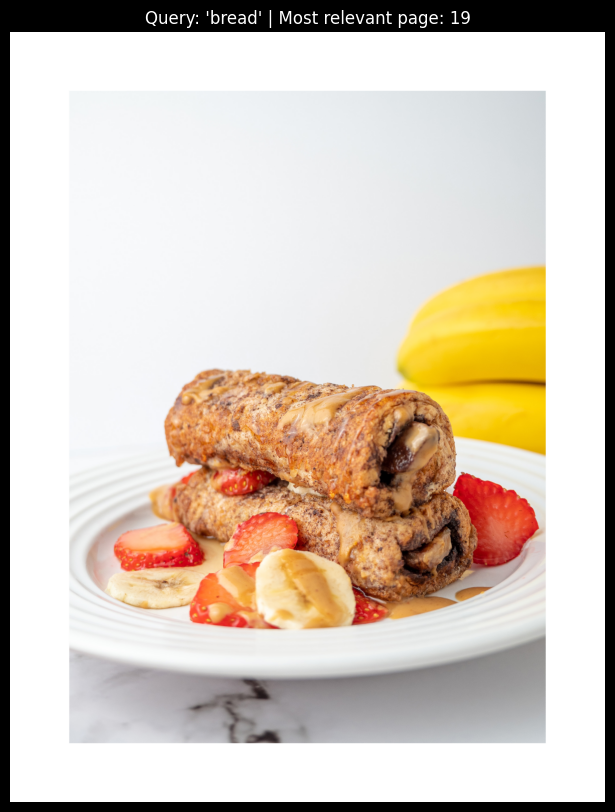

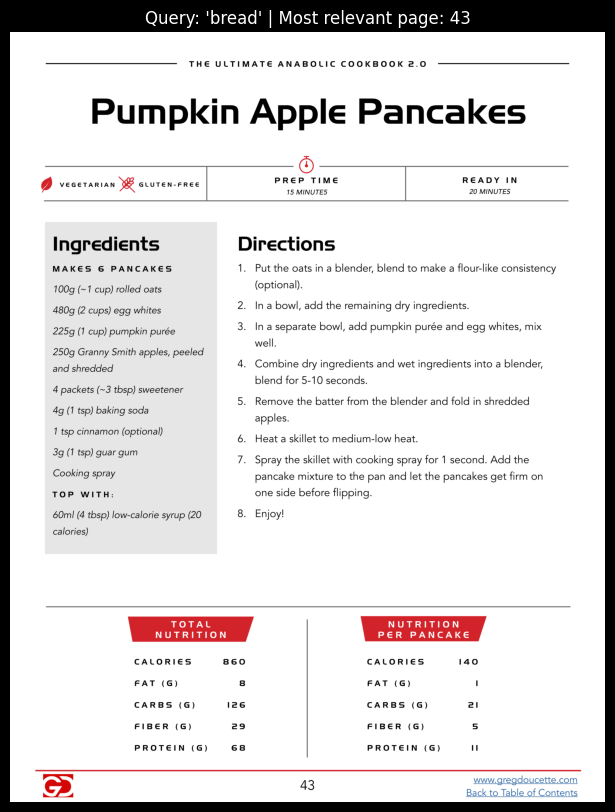

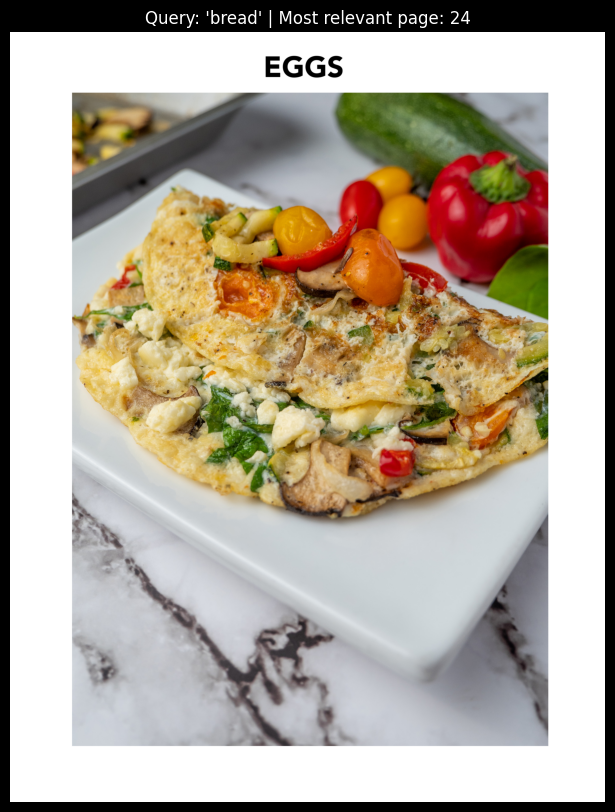

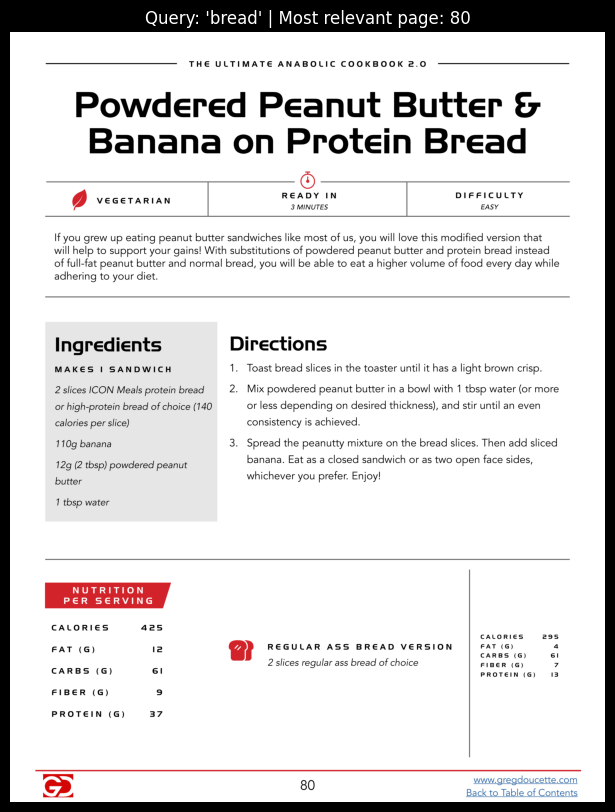

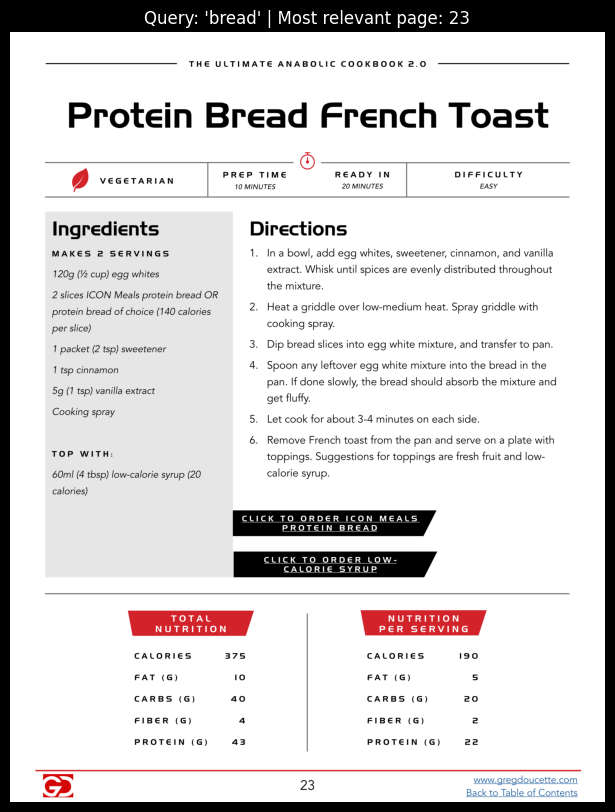

In [61]:
import fitz
import matplotlib.pyplot as plt

def display_relevant_pages(pdf_path, most_relevant_pages, query):
    # Open the PDF
    doc = fitz.open(pdf_path)

    # Iterate through the relevant pages
    for page_number in most_relevant_pages:
        page = doc.load_page(page_number) # Load the page
        
        # Get the image of the page
        img = page.get_pixmap(dpi=300)

        # Convert the Pixmap to a numpy array
        img_array = np.frombuffer(img.samples, dtype=np.uint8).reshape((img.height, img.width, img.n))

        # Display the image using Matplotlib
        plt.figure(figsize=(13, 10))
        plt.imshow(img_array)
        plt.title(f"Query: '{query}' | Most relevant page: {page_number + 1}")
        plt.axis('off') # Turn off axis
        plt.show()

    # Close the PDF document
    doc.close()


display_relevant_pages(pdf_path, most_relevant_pages, query)


Ok, we get relevant resources *along with* the source they came from!

That's the **retrieval** part of Retrieval Augmented Generation (RAG).

Before we get to the next two steps, let's take a small aside and discuss similarity measures.

### Similarity measures: dot product and cosine similarity 

Let's talk similarity measures between vectors.

Specifically, embedding vectors which are representations of data with magnitude and direction in high dimensional space (our embedding vectors have 768 dimensions).

The most common are the dot product and cosine similarity.

They are quite similar.

The main difference is that cosine similarity has a normalization step.

| Similarity measure | Description | Code |
| ----- | ----- | ----- |
| [Dot Product](https://en.wikipedia.org/wiki/Dot_product) | - Measure of magnitude and direction between two vectors<br>- Vectors that are aligned in direction and magnitude have a higher positive value<br>- Vectors that are opposite in direction and magnitude have a higher negative value | [`torch.dot`](https://pytorch.org/docs/stable/generated/torch.dot.html), [`np.dot`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html), [`sentence_transformers.util.dot_score`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.dot_score) | 
| [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) | - Vectors get normalized by magnitude/[Euclidean norm](https://en.wikipedia.org/wiki/Norm_(mathematics))/L2 norm so they have unit length and are compared more so on direction<br>- Vectors that are aligned in direction have a value close to 1<br>- Vectors that are opposite in direction have a value close to -1 | [`torch.nn.functional.cosine_similarity`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html), [`1 - scipy.spatial.distance.cosine`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html) (subtract the distance from 1 for similarity measure), [`sentence_transformers.util.cos_sim`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.cos_sim) |

For text similarity, you generally want to use cosine similarity as you are after the semantic measurements (direction) rather than magnitude. 

In our case, our embedding model `all-mpnet-base-v2` outputs normalized outputs (see the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#usage-huggingface-transformers) for more on this) so dot product and cosine similarity return the same results. However, dot product is faster due to not need to perform a normalize step.

> **Note:** Similarity measures between vectors and embeddings can be used on any kind of embeddings, not just text embeddings. For example, you could measure image embedding similarity or audio embedding similarity. Or with text and image models like [CLIP](https://github.com/mlfoundations/open_clip), you can measure the similarity between text and image embeddings.

In [62]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")


def print_top_recipes(query: str,
                    embeddings: torch.tensor,
                    pages_and_chunks: list[dict]=pages_and_chunks,
                    n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        # Print the recipe
        print_wrapped(recipe_dataset.loc[recipe_dataset['page_number'] == pages_and_chunks[index]['page_number'], 'text'].values[0])
        print("\n")


In [63]:
print_top_recipes("bread", embeddings, pages_and_chunks, 5)

[INFO] Time taken to get scores on 644 embeddings: 0.00008 seconds.
Query: bread

Results:
Score: 0.5588
Page number: 18
TITLE: Anabolic French Toast - Per Serving CALORIES (in kcal): 270 FAT (in g): 1
CARBS (in g): 30 FIBER (in g): 6 PROTEIN (in g): 28  TITLE: Anabolic French
Toast - Large CALORIES (in kcal): 400 FAT (in g): 2 CARBS (in g): 48 FIBER (in
g): 9 PROTEIN (in g): 45  DIRECTIONS: 1. In a bowl, add egg whites, sweetener,
cinnamon, and vanilla extract. Whisk until spices are evenly distributed
throughout the mixture. 2. Heat a griddle over low-medium heat. Spray griddle
with cooking spray. 3. Dip bread slices into egg white mixture, and transfer to
pan. 4. Spoon any leftover egg white mixture on to the bread in the pan. If done
slowly, the bread should absorb the mixture and get fluffy. 5. Let cook for
about 3-4 minutes on each side. 6. Remove French toast from the pan and serve on
a plate with toppings. Suggestions for toppings are fresh fruit and low- calorie
syrup.  INGRED

## setup prompt formatter

In [64]:
def prompt_formatter(query: str, 
                     context_items: str) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    #context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
    context=context_items
    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """
    Inspire yourself on the following prompt, return a recipe that answers the query. Give yourself room to think. Don't return the thinking, only return the answer.

    You must include every detail in the following format:
    - Title
    - Macros (calories, fat, carbs, fiber, protein)
    - Directions
    - Ingredients
    - Prep time
    - Ready in time
    - Diet (vegan, vegetarian, etc.)
    - Category

    Make sure your answers are as explanatory as possible.
    Use the following examples as reference for the ideal answer style.

    \nExample 1:
    Query: Can you generate me a high protein breakfast recipe?
    Answer: 
    TITLE: Anabolic Apple Pie Breakfast Bake - Entire Batch
    CALORIES (in kcal): 3350
    FAT (in g): 17
    CARBS (in g): 464
    FIBER (in g): 46
    PROTEIN (in g): 265


    DIRECTIONS:
    1. Pre-heat the oven to 400°F (204°C).
    2. Chop the apples into small pieces.
    3. In a bowl, whisk egg whites, cinnamon, sweetener, and vanilla.
    4. Tear the bread into small pieces and place in a bowl with the egg whites, cinnamon, sweetener, and vanilla. Mix with your hands until the bread pieces are well soaked with the batter.
    5. Spray a casserole dish with cooking spray for 1 second. Pour the egg white/bread mixture into the casserole dish.
    6. Place the casserole dish uncovered in the middle rack and cook in the oven at 400°F/204°C for 40-50 minutes.

    INGREDIENTS:
    18 slices regular bread (or one loaf [570g] of regular bread)
    1920g (4 cartons/2000ml) egg whites
    21g (3 tbsp) cinnamon
    15g (1 tbsp) vanilla extract
    15 packets (⅝ cup) sweetener
    1500g or ~10 apples of your choice
    Cooking spray

    PREP TIME (in m): 20

    READY IN (in m): 60

    CATEGORY: Breakfast

    DIET: non-vegan , vegetarian

    \nExample 2:
    Query: Make me a snack, I like apples?
    Answer: 
    TITLE: Apple Cinnamon Protein Rice Cakes
    CALORIES (in kcal): 580
    FAT (in g): 7
    CARBS (in g): 85
    FIBER (in g): 10
    PROTEIN (in g): 45

    DIRECTIONS:
    1. Mix the chocolate protein powder and powdered peanut butter in a bowl. Slowly add water to make a liquid paste consistency. Add sweetener if you desire more sweetness.
    2. Spread the liquid paste over the rice cakes.
    3. Wash the apple and cut into thin slices, place on top of the rice cake.
    4. Sprinkle with cinnamon. Enjoy!

    INGREDIENTS:
    2 rice cakes
    30g chocolate protein powder
    20g powdered peanut butter
    Water as needed
    1 apple
    Cinnamon to taste

    PREP TIME (in m): 10

    READY IN (in m): 15

    CATEGORY: Treats

    DIET: non-vegan , vegetarian

    \nExample 3:
    Query: I want pizza for dinner, I have cauliflower?
    Answer: 
    TITLE: Cauliflower Pizza Crust - Total
    CALORIES (in kcal): 800
    FAT (in g): 5
    CARBS (in g): 128
    FIBER (in g): 21
    PROTEIN (in g): 56

    TITLE: Cauliflower Pizza Crust - Per Crust
    CALORIES (in kcal): 200
    FAT (in g): 1
    CARBS (in g): 32
    FIBER (in g): 5
    PROTEIN (in g): 14

    DIRECTIONS:
    1. OPTIONAL: Prep cauliflower rice (either see the recipe in this book on page 124 or purchase pre-cooked cauliflower rice.)
    2. Pre-heat the oven to 400°F/204°C.
    3. In a bowl mix flour, guar/xanthan gum, garlic powder, salt, oregano, and basil.
    4. Add in the Greek yogurt and fold together to form a ball.
    5. In another bowl combine cooked cauliflower rice and egg whites. Mix well.
    6. Add the cauliflower mixture to the flour mixture and mix well. You can use your hands or a hand blender.
    7. Let stand at room temperature for 20 minutes.
    8. Divide the mixture into six 150g portions.
    9. Cover a baking sheet with parchment paper and spread the mixture into a ‘circle’.
    10. Bake at 400°F/204°C for 30-35 minutes or until lightly browned.
    11. Remove from the oven and let cool for a few minutes.

    INGREDIENTS:
    100g (~7/8 cup) self-raising flour
    700g (3 cups) cooked cauliflower rice
    180g (¾ cup) egg whites
    250g (1 cup) 0% fat Greek yogurt
    9g (1 tbsp) guar/xanthan gum
    1 tsp garlic powder
    ¼ tsp Kosher salt
    ½ tsp oregano
    ½ tsp basil

    PREP TIME (in m): 10

    READY IN (in m): 45

    CATEGORY: Dinner

    DIET: non-vegan , vegetarian

    Now, Create a recipe inspired by the following context to answer the user query:
    {context}
    User query: {query}
    Answer:
    """


    # Update base prompt with context items and query   
    prompt = base_prompt.format(context=context, query=query)
    return prompt

In [65]:
def retrieve_relevant_recipe(query: str,
                    embeddings: torch.tensor,
                    pages_and_chunks: list[dict]=pages_and_chunks,
                    n_resources_to_return: int=5):
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    recipes = []
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        # Print the recipe
        recipes.append(recipe_dataset.loc[recipe_dataset['page_number'] == pages_and_chunks[index]['page_number'], 'text'].values[0])
    
    context= "\n-------------------------------------\n".join(recipes)
    
    return context

In [66]:
query = "chicken brocolli rice"
print(f"Query: {query}")

# Get relevant resources
context = retrieve_relevant_recipe(query=query,
                                                  embeddings=embeddings,n_resources_to_return=5)

print(context)
# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context)
print(prompt)

Query: chicken brocolli rice
[INFO] Time taken to get scores on 644 embeddings: 0.00006 seconds.
Query: chicken brocolli rice

Results:
TITLE: Cauliflower Pizza Crust - Total
CALORIES (in kcal): 800
FAT (in g): 5
CARBS (in g): 128
FIBER (in g): 21
PROTEIN (in g): 56

TITLE: Cauliflower Pizza Crust - Per Crust
CALORIES (in kcal): 200
FAT (in g): 1
CARBS (in g): 32
FIBER (in g): 5
PROTEIN (in g): 14

TITLE: Cauliflower PIzza Crust - Per 2 Meat Lovers Pizza
CALORIES (in kcal): 600
FAT (in g): 6
CARBS (in g): 83
FIBER (in g): 13
PROTEIN (in g): 52

TITLE: Cauliflower Pizza Crust - Per 2 Veggie Pizzas
CALORIES (in kcal): 595
FAT (in g): 5
CARBS (in g): 93
FIBER (in g): 17
PROTEIN (in g): 44

DIRECTIONS:
1. OPTIONAL: Prep cauliflower rice (either see the recipe in this 
book on page 124 or purchase pre-cooked cauliflower rice.)
2. Pre-heat the oven to 400°F/204°C.
3. In a bowl mix flour, guar/xanthan gum, garlic powder, salt, 
oregano, and basil.
4. Add in the Greek yogurt and fold together 

# Setup GPT-4o Methods.

In [67]:
%pip install openai

Note: you may need to restart the kernel to use updated packages.


In [68]:
#libraries
from CleanRecipeMethods import *
from UnitTestRecipe import *

In [69]:
def generate_recipe_with_RAG(query, embeddings, pages_and_chunks, model='ft:gpt-3.5-turbo-1106:personal:recipecreatorv7b:9XU88CKN'):
    """
    Generates a recipe using a Retrieval Augmented Generation (RAG) approach. It retrieves relevant context based on the query
    and generates a recipe using a language model.

    Args:
        query (str): The user's query for the recipe (e.g., "high protein breakfast").
        embeddings (torch.tensor): The embeddings of the text data.
        pages_and_chunks (list[dict]): The list of dictionaries containing the text chunks and associated metadata.
        model (str): The identifier of the language model to use.

    Returns:
        str: The generated recipe.
    """
    # Step 1: Retrieve relevant context based on the query
    context = retrieve_relevant_recipe(query=query, embeddings=embeddings, pages_and_chunks=pages_and_chunks)

    # Step 2: Format the prompt using the retrieved context
    prompt = prompt_formatter(query=query, context_items=context)

    # Step 3: Generate the recipe using the language model
    recipe = send_message_to_recipe_model(prompt, model=model)

    # Step 4: Return the generated recipe
    return recipe

# Example usage
query = "high protein breakfast with eggs"
recipe = generate_recipe_with_RAG(query=query, embeddings=embeddings, pages_and_chunks=pages_and_chunks, model ="gpt-4o-mini")
print(print_recipe(recipe))


[INFO] Time taken to get scores on 644 embeddings: 0.00006 seconds.
Query: high protein breakfast with eggs

Results:

  TITLE:  High-Protein Egg Scramble 
  INGREDIENTS: 
- 200g egg whites 
- 100g spinach, chopped 
- 50g bell pepper, diced 
- 30g onion, diced 
- 5g olive oil 
- 2g salt 
- 1g black pepper 
  DIRECTIONS: 
- Heat olive oil in a skillet over medium heat. 
- Sauté onion and bell pepper until soft. 
- Add spinach and cook until wilted. 
- Pour in egg whites and season with salt and pepper. 
- Cook, stirring frequently, until eggs are fully set. 
- Serve warm. 
  CALORIES:  360 
  FAT:  22 
  CARBS:  18 
  PROTEIN:  36 
  PREP TIME:  10 
  TYPE:  breakfast_and_brunch 
  DIET:  non-vegan 
 



In [70]:
queries = [
        "chicken salad",
        "vegan lasagna",
        "high protein breakfast",
        "chocolate dessert",
        "gluten-free pasta",
        "quick dinner with chicken and broccoli",
        "healthy snack with almonds",
        "oatmeal breakfast",
        "beef stew",
        "recipe without clear ingredients"
    ]

for query in queries:
    print(f"Query: {query}\n")
    recipe = generate_recipe_with_RAG(query=query, embeddings=embeddings, pages_and_chunks=pages_and_chunks, model ="gpt-4o-mini")
    print(print_recipe(recipe))
    
    print("\n................................................\n")

Query: chicken salad

[INFO] Time taken to get scores on 644 embeddings: 0.00007 seconds.
Query: chicken salad

Results:

  TITLE:  Classic Chicken Salad 
  INGREDIENTS: 
- 300g chicken breast, cooked and shredded 
- 100g mayonnaise 
- 50g celery, diced 
- 50g red onion, diced 
- 30g Dijon mustard 
- 10g fresh parsley, chopped 
- salt to taste 
- pepper to taste 
  DIRECTIONS: 
- In a large bowl, combine the shredded chicken, mayonnaise, celery, red onion, Dijon mustard, and parsley. 
- Mix well until all ingredients are evenly coated. 
- Season with salt and pepper to taste. 
- Chill in the refrigerator for at least 30 minutes before serving. 
  CALORIES:  420 
  FAT:  30 
  CARBS:  8 
  PROTEIN:  36 
  PREP TIME:  15 
  TYPE:  lunch 
  DIET:  contains_meat 
 


................................................

Query: vegan lasagna

[INFO] Time taken to get scores on 644 embeddings: 0.00006 seconds.
Query: vegan lasagna

Results:

  TITLE: Vegan Vegetable Lasagna
  INGREDIENTS: 
-300g

# Create a recipe based on user questions

In [71]:
def generate_recipe_based_on_questions():
    # 1. Gather user input for each question
    dish_type = input("What kind of dish do you want to make? (Breakfast, lunch, dinner, dessert, appetizer, snacks): ")
    number_of_people = int(input("For how many people? (between 1 and 8): "))
    
    diets = []
    for i in range(number_of_people):
        diet = input(f"What is the diet for person {i+1}? (vegan, vegetarian, pescetarian, no gluten, no lactose, none): ")
        diets.append(diet)
    
    restrictions = []
    for i in range(number_of_people):
        restriction = input(f"What are the restrictions or dislikes for person {i+1}? (list ingredients, separated by commas): ")
        restrictions.append(restriction.split(','))
    
    ingredients = input("What ingredients would you like the recipe to have? (list up to 5 ingredients, separated by commas): ").split(',')
    max_time = input("How much time would you like the recipe to take to prepare? (at most 15 min, between 15-30 min, 30 min or more): ")
    cooking_tools = input("What are your cooking tools? (list available tools, separated by commas): ").split(',')

    # 2. Build the context for the recipe
    context = f"""
    Dish Type: {dish_type}
    Number of People: {number_of_people}
    Diets: {', '.join(diets)}
    Restrictions:
    """
    for i in range(number_of_people):
        context += f"Person {i+1}: {', '.join(restrictions[i])}\n"
    context += f"Preferred Ingredients: {', '.join(ingredients)}\n"
    context += f"Maximum Preparation Time: {max_time}\n"
    context += f"Available Cooking Tools: {', '.join(cooking_tools)}"

    # 3. Format the prompt for the recipe model
    prompt = f"""
    You are an expert chef. Create a recipe based on the following criteria:
    {context}
    
    The recipe must strictly adhere to the following guidelines:
    1. Respect all dietary restrictions and dislikes.
    2. Use the preferred ingredients where possible.
    3. The preparation time should not exceed the specified maximum time.
    4. The recipe should be suitable for the number of people specified.
    5. The recipe should only require the specified cooking tools.

    Please provide the recipe with the following details:
    - Title
    - Ingredients (including quantities)
    - Directions
    - Nutritional information (calories, fat, carbs, protein)
    - Preparation time
    - Category
    - Diet
    """

    # 4. Generate the recipe using the model
    recipe = send_message_to_recipe_model(prompt, model='gpt-4o-mini')

    # 5. Return the generated recipe
    return recipe

# Example usage
recipe=generate_recipe_based_on_questions()


In [72]:
print(print_recipe(recipe))


  TITLE: Fruit and Cheese Toasts 
  INGREDIENTS: 
-6 slices bread 
-180 g vegan cheese 
-3 kiwi, sliced 
-1 banana, sliced 
-1 tablespoon agave syrup 
-1 tablespoon lemon juice 
  DIRECTIONS: 
- Preheat the oven to 180°C (350°F). 
- In a bowl, mix the sliced fruits with lemon juice and agave syrup. 
- Place the bread slices on a baking sheet. 
- Top each slice with vegan cheese and a layer of the mixed fruits. 
- Bake in the oven for 5-7 minutes until the cheese is melted. 
- Serve warm. 
  CALORIES:  200 
  FAT:  4 
  CARBS:  35 
  PROTEIN:  6 
  PREP TIME:  15 
  TYPE:  breakfast_and_brunch 
  DIET:  vegan 
 



In [73]:
def suggest_alternative(ingredient, diet):
    """Suggests an alternative ingredient based on the diet."""
    alternatives = {
        'vegan': {
            'chicken': 'vegan chicken',
            'beef': 'vegan beef',
            'milk': 'plant-based milk',
            'cheese': 'vegan cheese',
            'eggs': 'egg substitute'
        },
        'vegetarian': {
            'chicken': 'tofu',
            'beef': 'soy protein',
            'fish': 'tempeh',
            'gelatin': 'agar-agar'
        },
        'no gluten': {
            'wheat': 'gluten-free flour',
            'soy sauce': 'tamari',
            'barley': 'quinoa'
        },
        'no lactose': {
            'milk': 'lactose-free milk',
            'cheese': 'lactose-free cheese',
            'cream': 'coconut cream'
        }
    }
    return alternatives.get(diet, {}).get(ingredient, ingredient)

def generate_recipe_based_on_questions_with_RAG(model='gpt-4o-mini'):
    # 1. Gather user input for each question
    dish_type = input("What kind of dish do you want to make? (Breakfast, lunch, dinner, dessert, appetizer, snacks): ").strip().capitalize()
    number_of_people = int(input("For how many people? (between 1 and 8): "))
    
    diets = []
    for i in range(number_of_people):
        diet = input(f"What is the diet for person {i+1}? (vegan, vegetarian, pescetarian, no gluten, no lactose, none): ").strip().lower()
        diets.append(diet)
    
    restrictions = []
    for i in range(number_of_people):
        restriction = input(f"What are the restrictions or dislikes for person {i+1}? (list ingredients, separated by commas): ")
        restrictions.append([r.strip().lower() for r in restriction.split(',')])
    
    ingredients = [ing.strip().lower() for ing in input("What ingredients would you like the recipe to have? (list up to 5 ingredients, separated by commas): ").split(',')]
    max_time = input("How much time would you like the recipe to take to prepare? (at most 15 min, between 15-30 min, 30 min or more): ").strip().lower()
    cooking_tools = [tool.strip().lower() for tool in input("What are your cooking tools? (list available tools, separated by commas): ").split(',')]

    # 2. Check for incompatible ingredients and suggest alternatives
    compatible_ingredients = []
    for ingredient in ingredients:
        for diet in diets:
            alternative = suggest_alternative(ingredient, diet)
            if alternative != ingredient:
                print(f"For the {diet} diet, replacing {ingredient} with {alternative}.")
            ingredient = alternative
        compatible_ingredients.append(ingredient)

    # 3. Build the context for the recipe
    context = f"""
    Dish Type: {dish_type}
    Number of People: {number_of_people}
    Diets: {', '.join(diets)}
    Restrictions:
    """
    for i in range(number_of_people):
        context += f"Person {i+1}: {', '.join(restrictions[i])}\n"
    context += f"Preferred Ingredients: {', '.join(compatible_ingredients)}\n"
    context += f"Maximum Preparation Time: {max_time}\n"
    context += f"Available Cooking Tools: {', '.join(cooking_tools)}"

    # 4. Format the prompt for the recipe model
    prompt = f"""
    You are an expert chef. Create a recipe based on the following criteria:
    {context}
    
    The recipe must strictly adhere to the following guidelines:
    1. Respect all dietary restrictions and dislikes. Do not include any ingredients that are listed as restrictions. 
       If a restriction such as "red fruits" is specified, ensure no red fruits are included.
    2. Use the preferred ingredients where possible, substituting alternatives if they conflict with any dietary restrictions or dislikes.
    3. The preparation time should not exceed the specified maximum time.
    4. The recipe should be suitable for the number of people specified.
    5. The recipe should only require the specified cooking tools.

    Please provide the recipe with the following details:
    - Title
    - Ingredients (including quantities)
    - Directions
    - Nutritional information (calories, fat, carbs, protein)
    - Preparation time
    - Category
    - Diet
    """

    # 5. Generate the recipe using the RAG method
    recipe = generate_recipe_with_RAG(prompt, embeddings, pages_and_chunks, model=model)

    # 6. Return the generated recipe
    return recipe

# Example usage
print(generate_recipe_based_on_questions_with_RAG())


For the vegan diet, replacing chicken with vegan chicken.
[INFO] Time taken to get scores on 644 embeddings: 0.00006 seconds.
Query: 
    You are an expert chef. Create a recipe based on the following criteria:
    
    Dish Type: Lunch
    Number of People: 2
    Diets: vegan, no gluten
    Restrictions:
    Person 1: nuts
Person 2: red fruits
Preferred Ingredients: vegan chicken, brocoli, rice
Maximum Preparation Time: 15-30 min
Available Cooking Tools: oven, microwave, stovetop, blender, automatic cooker, fryer
    
    The recipe must strictly adhere to the following guidelines:
    1. Respect all dietary restrictions and dislikes. Do not include any ingredients that are listed as restrictions. 
       If a restriction such as "red fruits" is specified, ensure no red fruits are included.
    2. Use the preferred ingredients where possible, substituting alternatives if they conflict with any dietary restrictions or dislikes.
    3. The preparation time should not exceed the specifie

In [75]:
print(print_recipe("<title_start>Vegan Chicken Broccoli Rice Bowl<title_end> <ingredient_start>200g vegan chicken <ingredient_next>200g broccoli, chopped <ingredient_next>150g brown rice <ingredient_next>15ml olive oil <ingredient_next>1 clove garlic, minced <ingredient_next>1 tsp soy sauce <ingredient_next>salt to taste <ingredient_end> <directions_start>1. Cook brown rice according to package instructions. <directions_next>2. In a frying pan, heat olive oil over medium heat. <directions_next>3. Add minced garlic and sauté for 1 minute until fragrant. <directions_next>4. Add vegan chicken and cook until browned, about 5-7 minutes. <directions_next>5. Add chopped broccoli and soy sauce, cover, and steam for 5 minutes until broccoli is tender. <directions_next>6. Serve the vegan chicken and broccoli over the cooked brown rice, season with salt to taste. <directions_end> <calories_start>590<calories_end> <fatcontent_start>18<fatcontent_end> <carbohydratecontent_start>72<carbohydratecontent_end> <proteincontent_start>26<proteincontent_end> <prep_time_min_start>15<prep_time_min_end> <type_start>lunch<type_end> <diet_start>vegan, gluten_free<diet_end> <recipe_end>"))

 TITLE: Vegan Chicken Broccoli Rice Bowl
  INGREDIENTS: 
-200g vegan chicken 
-200g broccoli, chopped 
-150g brown rice 
-15ml olive oil 
-1 clove garlic, minced 
-1 tsp soy sauce 
-salt to taste 
  DIRECTIONS: 
-1. Cook brown rice according to package instructions. 
-2. In a frying pan, heat olive oil over medium heat. 
-3. Add minced garlic and sauté for 1 minute until fragrant. 
-4. Add vegan chicken and cook until browned, about 5-7 minutes. 
-5. Add chopped broccoli and soy sauce, cover, and steam for 5 minutes until broccoli is tender. 
-6. Serve the vegan chicken and broccoli over the cooked brown rice, season with salt to taste. 
  CALORIES: 590
  FAT: 18
  CARBS: 72
  PROTEIN: 26
  PREP TIME: 15
  TYPE: lunch
  DIET: vegan, gluten_free
 

